In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

print('Pytorch version: ', torch.__version__)
print('GPU availability: ', torch.cuda.is_available())

Pytorch version:  1.12.1+cu113
GPU availability:  True


**Question 4 Part 1**

In [2]:
#Dataset class for Part 1
class BiDataset(Dataset):
    def __init__(self, size=512, num_bits=16, zfills=17, flag="train"):
        self.num_bits = num_bits
        self.size = size
        self.flag = flag
        
        assert zfills > num_bits
        self.zfills = zfills
  
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        a = np.random.randint(0, 2**self.num_bits)
        b = np.random.randint(0, 2**self.num_bits)
        c = a + b

        a_bin = format(a, 'b').zfill(self.zfills)[::-1]
        b_bin = format(b, 'b').zfill(self.zfills)[::-1]
        c_bin = format(c, 'b').zfill(self.zfills)[::-1]
        
        size  = len(a_bin)
      
        
        X = np.zeros((size,2),dtype=np.float32)
        y = np.zeros((len(c_bin)), dtype=np.float32)
        for i in range(0, size):
          X[i,0]=a_bin[i] 
          X[i,1]=b_bin[i]
          y[i]=c_bin[i]
      
        X_tensor = torch.from_numpy(X)
        y_tensor = torch.from_numpy(y)
        if self.flag=="train":
          return X_tensor, y_tensor
        else:
          return a, b, a_bin, b_bin, X_tensor, y_tensor


In [3]:
#Creating and loading dataset
np.random.seed(0)
training_set = BiDataset(size=512, num_bits=16, zfills=17, flag="train")

params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 2}

train_loader = DataLoader(training_set, **params)

In [4]:
#Model for Part 1
class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNNModel, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return hidden

In [5]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [6]:
input_dim = 2
hidden_dim = 10
layer_dim = 1
output_dim = 1
lr = 0.01
epochs = 100

model = RNNModel(input_size=input_dim, output_size=output_dim, hidden_dim=hidden_dim, n_layers=layer_dim)
model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
# Directory to save best model
model_dir = "Best_Model"
model_name = "model.pt"
try: 
    if os.path.exists(model_dir) == False:
        os.mkdir(model_dir)
except OSError as error: 
    print(error)
model_path = model_dir+"/"+model_name


Epoch: 1/100............. Train loss: 0.0054
Epoch: 2/100............. Train loss: 0.0054
Epoch: 3/100............. Train loss: 0.0054
Epoch: 4/100............. Train loss: 0.0054
Epoch: 5/100............. Train loss: 0.0054
Epoch: 6/100............. Train loss: 0.0054
Epoch: 7/100............. Train loss: 0.0054
Epoch: 8/100............. Train loss: 0.0054
Epoch: 9/100............. Train loss: 0.0054
Epoch: 10/100............. Train loss: 0.0054
Epoch: 11/100............. Train loss: 0.0054
Epoch: 12/100............. Train loss: 0.0054
Epoch: 13/100............. Train loss: 0.0054
Epoch: 14/100............. Train loss: 0.0054
Epoch: 15/100............. Train loss: 0.0054
Epoch: 16/100............. Train loss: 0.0054
Epoch: 17/100............. Train loss: 0.0053
Epoch: 18/100............. Train loss: 0.0053
Epoch: 19/100............. Train loss: 0.0053
Epoch: 20/100............. Train loss: 0.0053
Epoch: 21/100............. Train loss: 0.0052
Epoch: 22/100............. Train loss: 0.00

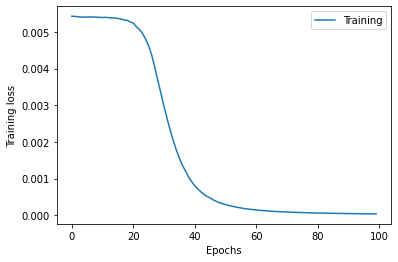

In [8]:
# Training the  model
best_loss = 512
avg_train_loss = list()
all_epochs     = list()
for epoch in range(0, epochs):
  total_train_loss = 0.0
  avg_acc = 0.0
  for i, (biNums, labels) in enumerate(train_loader):
    optimizer.zero_grad() 
    biNums = biNums.to(device)
    labels = labels.to(device)
    output, hidden = model(biNums)
    output = output.to(device)

    labels = labels.view(-1)
    output = output.view(-1)
    
    loss = criterion(output, labels)
    total_train_loss += loss.item()
    
    loss.backward() 
    optimizer.step()  
  avg_loss = total_train_loss/len(train_loader.sampler)

  avg_train_loss.append(avg_loss)
  all_epochs.append(epoch)

  #saving best performing model
  if best_loss>avg_loss:
    best_loss = avg_loss
    torch.save(model.state_dict(), model_path)

  print('Epoch: {}/{}.............'.format(epoch+1, epochs), end=' ')
  print("Train loss: {:.4f}".format(avg_loss))
print("Best loss: {:.4f}".format(best_loss) )

plt.plot(all_epochs, avg_train_loss, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.legend()
plt.show()

In [9]:
#Generating five examples for testing model
np.random.seed(0)
test_set = BiDataset(size=5, num_bits=16, zfills=17, flag="test")

params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 2}

test_loader = DataLoader(test_set, **params)

In [10]:
#loading the best model
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval()

correct_cnt = 0
#Deploying the best model
with torch.no_grad():
  print("Part 1 deployment results: ")
  for batch_idx, (a, b, a_bin, b_bin, x_test, target) in enumerate(test_loader):
      x_test, target = x_test.to(device), target.to(device)
     
      out, hidden = model(x_test)
      
      out = out.reshape((len(out), -1))
      target = target.reshape((len(target), -1))
    
      preds_bool  = out>0.5
      preds_float = torch.as_tensor(preds_bool, dtype=torch.float32)
      preds_float = preds_float.view(-1)
      target = target.view(-1)

      target = target.cpu().detach().numpy()
      preds_float = preds_float.cpu().detach().numpy()
      output = np.asarray(preds_float, dtype=int)
      label = np.asarray(target, dtype=int)
      accuracy    = accuracy_score(target, preds_float)
      
      print('Test number {}: Integer1: {}, Integer2: {}, Integer1 binary: {},'.format(batch_idx+1, a.item(), b.item(), a_bin), end=' ')
      print(' Integer2 binary: {}, Label: {}, Predicted: {}, Correctly predicted: digits: {:.2f}%'.format( b_bin, label, output, (accuracy*100)))
      print()

Part 1 deployment results: 
Test number 1: Integer1: 43606, Integer2: 17871, Integer1 binary: ('01101010010101010',),  Integer2 binary: ('11110011101000100',), Label: [1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0], Predicted: [1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0], Correctly predicted: digits: 100.00%

Test number 2: Integer1: 18702, Integer2: 13085, Integer1 binary: ('01110000100100100',),  Integer2 binary: ('10111000110011000',), Label: [1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0], Predicted: [1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0], Correctly predicted: digits: 100.00%

Test number 3: Integer1: 51900, Integer2: 48274, Integer1 binary: ('00111101010100110',),  Integer2 binary: ('01001001001111010',), Label: [0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1], Predicted: [0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1], Correctly predicted: digits: 100.00%

Test number 4: Integer1: 46974, Integer2: 50453, Integer1 binary: ('01111110111011010',),  Integer2 binary: ('10101000101000110',), Label: [1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1], Predicted:

**Question 4 Part 2**

In [11]:
#Dataset class for part 2
class BiDataset2(Dataset):
    def __init__(self, size=512, num_bits=16, zfills=17, flag="train"):
        self.num_bits = num_bits
        self.size = size
        self.flag = flag
        
        assert zfills > num_bits
        self.zfills = zfills
  
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        a = np.random.randint(0, 2**self.num_bits)
        b = np.random.randint(0, 2**self.num_bits)
        c = a + b

        a_bin = format(a, 'b').zfill(self.zfills)
        b_bin = format(b, 'b').zfill(self.zfills)
        c_bin = format(c, 'b').zfill(self.zfills)
        
        size  = len(a_bin)
        
        X = np.zeros((size,2),dtype=np.float32)
        y = np.zeros((len(c_bin)), dtype=np.float32)
        for i in range(0, size):
          X[i,0]=a_bin[i] 
          X[i,1]=b_bin[i]
          y[i]=c_bin[i]
      
        X_tensor = torch.from_numpy(X)
        y_tensor = torch.from_numpy(y)
        if self.flag=="train":
          return X_tensor, y_tensor
        else:
          return  a, b, a_bin, b_bin, X_tensor, y_tensor

In [12]:
#Creating and generating data
np.random.seed(0)
train_set2 = BiDataset2(size=512, num_bits=16, zfills=17, flag="train")

params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 2}

train_loader2 = DataLoader(train_set2, **params)

In [13]:
#Part 2 model
class RNNModel2(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(RNNModel2, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True) 

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out, hidden

In [14]:
input_dim = 2
hidden_dim = 100
layer_dim = 1
output_dim = 1
lr=0.01
epochs = 100

model = RNNModel2(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim, n_layers=layer_dim)
model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
model_name = "model2.pt"
model_path = model_dir+"/"+model_name

Epoch: 1/100............. Train loss: 0.0055
Epoch: 2/100............. Train loss: 0.0054
Epoch: 3/100............. Train loss: 0.0054
Epoch: 4/100............. Train loss: 0.0054
Epoch: 5/100............. Train loss: 0.0054
Epoch: 6/100............. Train loss: 0.0054
Epoch: 7/100............. Train loss: 0.0054
Epoch: 8/100............. Train loss: 0.0054
Epoch: 9/100............. Train loss: 0.0054
Epoch: 10/100............. Train loss: 0.0054
Epoch: 11/100............. Train loss: 0.0054
Epoch: 12/100............. Train loss: 0.0054
Epoch: 13/100............. Train loss: 0.0054
Epoch: 14/100............. Train loss: 0.0054
Epoch: 15/100............. Train loss: 0.0054
Epoch: 16/100............. Train loss: 0.0054
Epoch: 17/100............. Train loss: 0.0054
Epoch: 18/100............. Train loss: 0.0054
Epoch: 19/100............. Train loss: 0.0054
Epoch: 20/100............. Train loss: 0.0054
Epoch: 21/100............. Train loss: 0.0054
Epoch: 22/100............. Train loss: 0.00

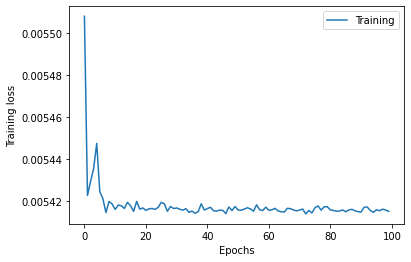

In [16]:
# Training the model
best_loss = 512
avg_train_loss = list()
all_epochs     = list()

for epoch in range(0, epochs):
  total_train_loss = 0.0
  avg_acc = 0.0
  for i, (biNums, labels) in enumerate(train_loader2):
    optimizer.zero_grad() 
    biNums = biNums.to(device)
    labels = labels.to(device)
    output, hidden = model(biNums)
    output = output.to(device)
  
    labels = labels.view(-1)
    output = output.view(-1)
    
    loss = criterion(output, labels)
    total_train_loss += loss.item()
    
    loss.backward() 
    optimizer.step() 
    
  avg_loss = total_train_loss/len(train_loader2.sampler)
  avg_train_loss.append(avg_loss)
  all_epochs.append(epoch)
  
  #saving best performing model
  if best_loss>avg_loss:
    best_loss = avg_loss
    torch.save(model.state_dict(), model_path)
  print('Epoch: {}/{}.............'.format(epoch+1, epochs), end=' ')
  print("Train loss: {:.4f}".format(avg_loss))
print("Best loss: {:.4f}".format(best_loss) )
plt.plot(all_epochs, avg_train_loss, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.legend()
plt.show()

In [17]:
#Generating 5 samples for deployment
np.random.seed(0)
test_set2 = BiDataset(size=5, num_bits=16, zfills=17, flag="test")

params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 2}

test_loader2 = DataLoader(test_set2, **params)

In [18]:
#loading the best model
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval()

correct_cnt = 0
#Deploying best model
with torch.no_grad():
  print("Deployment results for Part 2: ")
  for batch_idx, (a, b, a_bin, b_bin, x_test, target) in enumerate(test_loader2):
      x_test, target = x_test.to(device), target.to(device)
     
      out, hidden = model(x_test)
      
      out = out.reshape((len(out), -1))
      target = target.reshape((len(target), -1))
    
      preds_bool  = out>0.5
      preds_float = torch.as_tensor(preds_bool, dtype=torch.float32)
      preds_float = preds_float.view(-1)
      target = target.view(-1)

      target = target.cpu().detach().numpy()
      preds_float = preds_float.cpu().detach().numpy()
      output = np.asarray(preds_float, dtype=int)
      label = np.asarray(target, dtype=int)
      accuracy    = accuracy_score(target, preds_float)
  
      print('Test number {}: Integer1: {}, Integer2: {}, Integer1 binary: {},'.format(batch_idx+1, a.item(), b.item(), a_bin), end=' ')
      print(' Integer2 binary: {}, Label: {}, Predicted: {}, Correctly predicted: digits: {:.2f}%'.format( b_bin, label, output, (accuracy*100)))
      print()

Deployment results for Part 2: 
Test number 1: Integer1: 13311, Integer2: 26770, Integer1 binary: ('11111111110011000',),  Integer2 binary: ('01001001000101100',), Label: [1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 0], Predicted: [1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1], Correctly predicted: digits: 41.18%

Test number 2: Integer1: 5655, Integer2: 33822, Integer1 binary: ('11101000011010000',),  Integer2 binary: ('01111000001000010',), Label: [1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0], Predicted: [1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1], Correctly predicted: digits: 41.18%

Test number 3: Integer1: 11381, Integer2: 50783, Integer1 binary: ('10101110001101000',),  Integer2 binary: ('11111010011000110',), Label: [0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0], Predicted: [0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1], Correctly predicted: digits: 47.06%

Test number 4: Integer1: 3013, Integer2: 54386, Integer1 binary: ('10100011110100000',),  Integer2 binary: ('01001110001010110',), Label: [1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0], Predicted: 